<a href="https://colab.research.google.com/github/abhimnc/humanAI/blob/main/dance_ai_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Motion Capture Analysis and Visualization
# Install required packages
!pip install torch torch-geometric numpy matplotlib tqdm ipython
# Create necessary directories
!mkdir -p data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.

Motion Capture Visualization for Google Colab
---------------------------------------------
Loading data from /content/drive/MyDrive/GSC/mariel_*.npy...
Original numpy dataset contains 28,384 timesteps of 53 joints with 3 dimensions each.
loc_min: -2.024727689670035 loc_max: 1.4889235132175602
vel_min: -47.28208003340422 vel_max: 35.22286131457118
loc_min: -0.5025142730093427 loc_max: 0.9631355127223595
vel_min: -47.28208003340422 vel_max: 35.22286131457118
Number of frames to visualize (default: 100): 100
Show cloud connections? (y/n, default: n): n
Creating animation with 100 frames...


<ipython-input-3-54aa388b2f13>:290: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap(cmap)
<ipython-input-3-54aa388b2f13>:304: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  pts = ax.scatter(seq[0,:,0],seq[0,:,1],seq[0,:,2], c=dot_color, s=dot_size, cmap=cm, alpha=dot_alpha)
Skeleton lines: 100%|██████████| 58/58 [00:00<00:00, 1569.23it/s]


Displaying animation in the notebook...


Animation process complete!


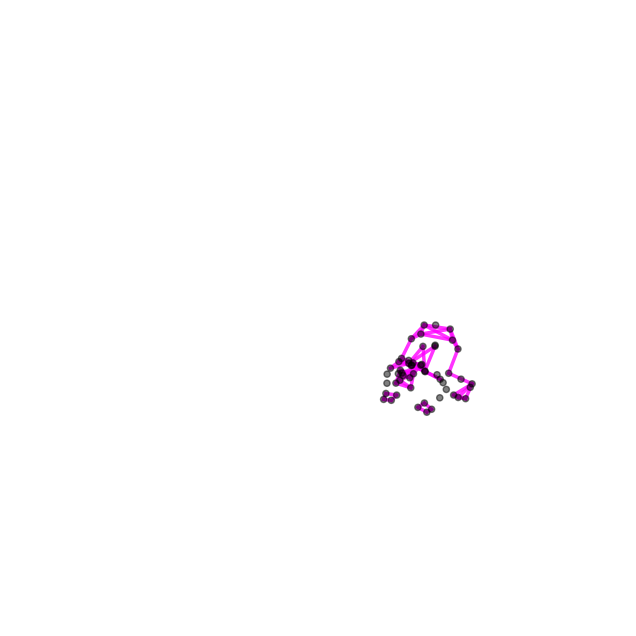

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation
from mpl_toolkits.mplot3d.art3d import juggle_axes
from tqdm import tqdm
import os
import sys
from glob import glob
import io
from google.colab import files
from IPython.display import HTML, display

# Set the animation backend for Colab
plt.rcParams['animation.html'] = 'jshtml'

def load_data(pattern="mariel_*.npy"):
    # load up the six datasets, performing some minimal preprocessing beforehand
    datasets = {}
    ds_all = []

    exclude_points = [26,53]
    point_mask = np.ones(55, dtype=bool)
    point_mask[exclude_points] = 0

    for f in sorted(glob(pattern)):
        ds_name = os.path.basename(f)[7:-4]
        ds = np.load(f).transpose((1,0,2))
        ds = ds[500:-500, point_mask]
        ds[:,:,2] *= -1
        datasets[ds_name] = ds
        ds_all.append(ds)

    ds_counts = np.array([ds.shape[0] for ds in ds_all])
    ds_offsets = np.zeros_like(ds_counts)
    ds_offsets[1:] = np.cumsum(ds_counts[:-1])

    ds_all = np.concatenate(ds_all)
    print("Original numpy dataset contains {:,} timesteps of {} joints with {} dimensions each.".format(ds_all.shape[0], ds_all.shape[1], ds_all.shape[2]))

    low,hi = np.quantile(ds_all, [0.01,0.99], axis=(0,1))
    xy_min = min(low[:2])
    xy_max = max(hi[:2])
    xy_range = xy_max-xy_min
    ds_all[:,:,:2] -= xy_min
    ds_all *= 2/xy_range
    ds_all[:,:,:2] -= 1.0

    ### It's also useful to have these datasets centered, i.e. with the x and y offsets subtracted from each individual frame:
    ds_all_centered = ds_all.copy()
    ds_all_centered[:,:,:2] -= ds_all_centered[:,:,:2].mean(axis=1,keepdims=True)

    datasets_centered = {}
    for ds in datasets:
        datasets[ds][:,:,:2] -= xy_min
        datasets[ds] *= 2/xy_range
        datasets[ds][:,:,:2] -= 1.0
        datasets_centered[ds] = datasets[ds].copy()
        datasets_centered[ds][:,:,:2] -= datasets[ds][:,:,:2].mean(axis=1,keepdims=True)

    ### Calculate velocities (first velocity is always 0)
    velocities = np.vstack([np.zeros((1,53,3)),np.array([35*(ds_all[t+1,:,:] - ds_all[t,:,:]) for t in range(len(ds_all)-1)])]) # (delta_x/y/z per frame) * (35 frames/sec)

    ### Stack positions above velocities
    ds_all = np.dstack([ds_all,velocities]) # stack along the 3rd dimension, i.e. "depth-wise"
    ds_all_centered = np.dstack([ds_all_centered,velocities]) # stack along the 3rd dimension, i.e. "depth-wise"

    for data in [ds_all, ds_all_centered]:
        # Normalize locations & velocities (separately) to [-1, 1]
        loc_min = np.min(data[:,:,:3])
        loc_max = np.max(data[:,:,:3])
        vel_min = np.min(data[:,:,3:])
        vel_max = np.max(data[:,:,3:])
        print("loc_min:",loc_min,"loc_max:",loc_max)
        print("vel_min:",vel_min,"vel_max:",vel_max)
        data[:,:,:3] = (data[:,:,:3] - loc_min) * 2 / (loc_max - loc_min) - 1
        data[:,:,3:] = (data[:,:,3:] - vel_min) * 2 / (vel_max - vel_min) - 1

    return ds_all, ds_all_centered, datasets, datasets_centered, ds_counts

# Define the skeleton lines for visualization
point_labels = ['ARIEL','C7','CLAV','LANK','LBHD','LBSH','LBWT','LELB','LFHD','LFRM','LFSH','LFWT','LHEL','LIEL','LIHAND','LIWR','LKNE','LKNI','LMT1','LMT5','LOHAND','LOWR','LSHN','LTHI','LTOE','LUPA','MBWT','MFWT','RANK','RBHD','RBSH','RBWT','RELB','RFHD','RFRM','RFSH','RFWT','RHEL','RIEL','RIHAND','RIWR','RKNE','RKNI','RMT1','RMT5','ROHAND','ROWR','RSHN','RTHI','RTOE','RUPA','STRN','T10']

skeleton_lines = [
#     ( (start group), (end group) ),
    (('LHEL',), ('LTOE',)), # toe to heel
    (('RHEL',), ('RTOE',)),
    (('LMT1',), ('LMT5',)), # horizontal line across foot
    (('RMT1',), ('RMT5',)),
    (('LHEL',), ('LMT1',)), # heel to sides of feet
    (('LHEL',), ('LMT5',)),
    (('RHEL',), ('RMT1',)),
    (('RHEL',), ('RMT5',)),
    (('LTOE',), ('LMT1',)), # toe to sides of feet
    (('LTOE',), ('LMT5',)),
    (('RTOE',), ('RMT1',)),
    (('RTOE',), ('RMT5',)),
    (('LKNE',), ('LHEL',)), # heel to knee
    (('RKNE',), ('RHEL',)),
    (('LFWT',), ('RBWT',)), # connect pelvis
    (('RFWT',), ('LBWT',)),
    (('LFWT',), ('RFWT',)),
    (('LBWT',), ('RBWT',)),
    (('LFWT',), ('LBWT',)),
    (('RFWT',), ('RBWT',)),
    (('LFWT',), ('LTHI',)), # pelvis to thighs
    (('RFWT',), ('RTHI',)),
    (('LBWT',), ('LTHI',)),
    (('RBWT',), ('RTHI',)),
    (('LKNE',), ('LTHI',)),
    (('RKNE',), ('RTHI',)),
    (('CLAV',), ('LFSH',)), # clavicle to shoulders
    (('CLAV',), ('RFSH',)),
    (('STRN',), ('LFSH',)), # sternum & T10 (back sternum) to shoulders
    (('STRN',), ('RFSH',)),
    (('T10',), ('LFSH',)),
    (('T10',), ('RFSH',)),
    (('C7',), ('LBSH',)), # back clavicle to back shoulders
    (('C7',), ('RBSH',)),
    (('LFSH',), ('LBSH',)), # front shoulders to back shoulders
    (('RFSH',), ('RBSH',)),
    (('LFSH',), ('RBSH',)),
    (('RFSH',), ('LBSH',)),
    (('LFSH',), ('LUPA',),), # shoulders to upper arms
    (('RFSH',), ('RUPA',),),
    (('LBSH',), ('LUPA',),),
    (('RBSH',), ('RUPA',),),
    (('LIWR',), ('LIHAND',),), # wrist to hand
    (('RIWR',), ('RIHAND',),),
    (('LOWR',), ('LOHAND',),),
    (('ROWR',), ('ROHAND',),),
    (('LIWR',), ('LOWR',),), # across the wrist
    (('RIWR',), ('ROWR',),),
    (('LIHAND',), ('LOHAND',),), # across the palm
    (('RIHAND',), ('ROHAND',),),
    (('LFHD',), ('LBHD',)), # draw lines around circumference of the head
    (('LBHD',), ('RBHD',)),
    (('RBHD',), ('RFHD',)),
    (('RFHD',), ('LFHD',)),
    (('LFHD',), ('ARIEL',)), # connect circumference points to top of head
    (('LBHD',), ('ARIEL',)),
    (('RBHD',), ('ARIEL',)),
    (('RFHD',), ('ARIEL',)),
]

# Cloud of every point connected:
cloud_idxs = []
for i in range(53):
    for j in range(53):
        if i == j: continue # skip self-loops
        entry = []
        entry.append([i])
        entry.append([j])
        cloud_idxs.append(entry)

cloud_idxs_names = []
for i in range(53):
    for j in range(53):
        if i == j: continue # skip self-loops
        entry = []
        entry.append([point_labels[i]])
        entry.append([point_labels[j]])
        cloud_idxs_names.append(entry)

# Generate edges for visualization
skeleton_idxs = []
for g1,g2 in skeleton_lines:
    entry = []
    entry.append([point_labels.index(l) for l in g1])
    entry.append([point_labels.index(l) for l in g2])
    skeleton_idxs.append(entry)

all_idxs = skeleton_idxs+cloud_idxs

# calculate the coordinates for the lines
def get_line_segments(seq, zcolor=None, cmap=None, cloud=False, edge_types=None, edge_class=None):
    xline = np.zeros((seq.shape[0],len(all_idxs),3,2))
    if cmap:
        colors = np.zeros((len(all_idxs), 4))
    for edge,(joint1,joint2) in enumerate(all_idxs):
        xline[:,edge,:,0] = np.mean(seq[:,joint1], axis=1)
        xline[:,edge,:,1] = np.mean(seq[:,joint2], axis=1)
        if cmap:
            if edge_types is not None:
                if edge >= len(skeleton_idxs): # cloud edges
                    if edge_types[edge-len(skeleton_idxs), edge_class] == 1:
                        colors[edge] = cmap(1)
                    else:
                        colors[edge] = cmap(0)
            else:
                colors[edge] = cmap(0)
    if cmap:
        return xline, colors
    else:
        return xline

# put line segments on the given axis, with given colors
def put_lines(ax, segments, color=None, lw=2.5, alpha=None, skeleton=True, skeleton_alpha=0.3, cloud=False, cloud_alpha=0.03, threshold=0, edge_types=None, edge_opacities=None, edge_class=None):
    lines = []
    ### Main skeleton
    for i in tqdm(range(len(skeleton_idxs)), desc="Skeleton lines"):
        if isinstance(color, (list,tuple,np.ndarray)):
            c = color[i]
        else:
            c = color

        if skeleton: alpha=skeleton_alpha
        else: alpha=0

        ### THESE LINES PLOT THE MAIN SKELETON
        l = ax.plot(np.linspace(segments[i,0,0],segments[i,0,1],2),
                np.linspace(segments[i,1,0],segments[i,1,1],2),
                np.linspace(segments[i,2,0],segments[i,2,1],2),
                color=c,
                alpha=alpha,
                lw=lw)[0]
        lines.append(l)

    if cloud:
        ### Cloud of all-connected joints
        for i in tqdm(range(len(cloud_idxs)), desc="Cloud lines"):
            if isinstance(color, (list,tuple,np.ndarray)):
                c = color[i]
            else:
                c = color

            ### plot or don't plot lines based on edge class
            if edge_types is not None and edge_class is not None:
                custom_colors = ["deeppink","red","blue","green","orange"]
                if edge_types[i][edge_class] == 1:
                    if edge_opacities is not None and edge_opacities[i,edge_class] > threshold:
                        alpha=0.5
                    else:
                        alpha=cloud_alpha
                    l = ax.plot(
                        np.linspace(segments[i,0,0],segments[i,0,1],2),
                        np.linspace(segments[i,1,0],segments[i,1,1],2),
                        np.linspace(segments[i,2,0],segments[i,2,1],2),
                        color=custom_colors[edge_class],
                        alpha=alpha,
                        lw=lw)[0]
                    lines.append(l)
                else:
                    l = ax.plot(
                        np.linspace(segments[i,0,0],segments[i,0,1],2),
                        np.linspace(segments[i,1,0],segments[i,1,1],2),
                        np.linspace(segments[i,2,0],segments[i,2,1],2),
                        alpha=0,
                        color="white",
                        lw=lw)[0]
                    lines.append(None)

            else: # regular cloud
                l = ax.plot(
                np.linspace(segments[i,0,0],segments[i,0,1],2),
                np.linspace(segments[i,1,0],segments[i,1,1],2),
                np.linspace(segments[i,2,0],segments[i,2,1],2),
                alpha=cloud_alpha,
                lw=lw)[0]
                lines.append(l)
    return lines

# animate a video of the stick figure.
def animate_stick(seq, ghost=None, ghost_shift=0, edge_types=None, edge_opacities=None, threshold=0, edge_class=None, figsize=None, zcolor=None, pointer=None, ax_lims=(-0.4,0.4), speed=45,
                  dot_size=20, dot_alpha=0.5, lw=2.5, cmap='cool_r', pointer_color='black', cloud=False, cloud_alpha=0.03, skeleton=True, skeleton_alpha=0.3):
    if zcolor is None:
        zcolor = np.zeros(seq.shape[1])
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # The following lines eliminate background lines/axes:
    ax.axis('off')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    # Make the figure clean
    ax.grid(False)
    ax._axis3don = False  # This hides the 3D axes

    # set figure background opacity (alpha) to 0:
    fig.patch.set_alpha(0.)

    if ghost_shift and ghost is not None:
        seq = seq.copy()
        ghost = ghost.copy()
        seq[:,:,0] -= ghost_shift
        ghost[:,:,0] += ghost_shift

    cm = plt.cm.get_cmap(cmap)

    if edge_types is not None:
        num_connections = np.zeros((53))
        for edge,(joint1,joint2) in enumerate(all_idxs):
            if edge > len(skeleton_idxs) and edge_types[edge - len(skeleton_idxs),edge_class] == 1:
                num_connections[joint1] += 1
                num_connections[joint2] += 1
        num_connections = num_connections/np.sum(num_connections) # normalize so colormap can use values between 0 and 1
        dot_color = [cm(num_connections[joint]) for joint in range(53)]
        pts = ax.scatter(seq[0,:,0],seq[0,:,1],seq[0,:,2], c=dot_color, s=dot_size, cmap=cm, alpha=dot_alpha)

    else:
        dot_color = "black"
        pts = ax.scatter(seq[0,:,0],seq[0,:,1],seq[0,:,2], c=dot_color, s=dot_size, cmap=cm, alpha=dot_alpha)

    ghost_color = 'blue'

    if ghost is not None:
        pts_g = ax.scatter(ghost[0,:,0],ghost[0,:,1],ghost[0,:,2], c=ghost_color, s=dot_size, alpha=dot_alpha)

    if ax_lims:
        ax.set_xlim(*ax_lims)
        ax.set_ylim(*ax_lims)
        ax.set_zlim(0,ax_lims[1]-ax_lims[0])

    xline, colors = get_line_segments(seq, zcolor, cm, edge_types=edge_types, edge_class=edge_class)
    lines = put_lines(ax, xline[0], color=colors, lw=lw, alpha=0.9, cloud=cloud, cloud_alpha=cloud_alpha, edge_types=edge_types, edge_opacities=edge_opacities, threshold=threshold, edge_class=edge_class, skeleton=skeleton, skeleton_alpha=skeleton_alpha)

    if ghost is not None:
        xline_g = get_line_segments(ghost)
        lines_g = put_lines(ax, xline_g[0], ghost_color, lw=lw, alpha=1.0, cloud=cloud, cloud_alpha=cloud_alpha, skeleton=skeleton, skeleton_alpha=skeleton_alpha)

    if pointer is not None:
        vR = 0.15
        dX,dY = vR*np.cos(pointer), vR*np.sin(pointer)
        zidx = point_labels.index('CLAV')
        X = seq[:,zidx,0]
        Y = seq[:,zidx,1]
        Z = seq[:,zidx,2]
        quiv = ax.quiver(X[0],Y[0],Z[0],dX[0],dY[0],0, color=pointer_color)
        ax.quiv = quiv

    def update(t):
        pts._offsets3d = juggle_axes(seq[t,:,0], seq[t,:,1], seq[t,:,2], 'z')
        for i,l in enumerate(lines):
            if l is not None:
                l.set_data(xline[t,i,:2])
                l.set_3d_properties(xline[t,i,2])

        if ghost is not None:
            pts_g._offsets3d = juggle_axes(ghost[t,:,0], ghost[t,:,1], ghost[t,:,2], 'z')
            for i,l in enumerate(lines_g):
                l.set_data(xline_g[t,i,:2])
                l.set_3d_properties(xline_g[t,i,2])

        if pointer is not None:
            ax.quiv.remove()
            ax.quiv = ax.quiver(X[t],Y[t],Z[t],dX[t],dY[t],0,color=pointer_color)

    return animation.FuncAnimation(
        fig,
        update,
        len(seq),
        interval=speed,
        blit=False,
   )

def save_animation(animation_obj, filename='motion_capture_video.mp4', fps=20, bitrate=1800, codec='h264'):
    """
    Save the animation as a video file.

    Parameters:
        animation_obj: The animation object returned by animate_stick
        filename: The output video filename (should end with .mp4)
        fps: Frames per second
        bitrate: Video bitrate
        codec: Video codec to use
    """
    print(f"Saving animation to {filename}...")

    # Create writer object
    writer = animation.FFMpegWriter(
        fps=fps,
        metadata=dict(artist='Motion Capture Visualization'),
        bitrate=bitrate,
        codec=codec
    )

    # Save the animation
    animation_obj.save(filename, writer=writer)
    print(f"Video saved successfully to {filename}!")

    # Download the file automatically in Colab
    try:
        from google.colab import files
        files.download(filename)
        print(f"File {filename} is ready to download.")
    except Exception as e:
        print(f"Note: Could not auto-download file: {e}")

    return filename

def create_sample_data():
    """
    Create a sample dataset for testing when real data is not available.
    Returns a simple walking motion simulation.
    """
    print("Creating sample motion data...")

    # Number of frames, joints, and dimensions
    n_frames = 100
    n_joints = 53
    n_dims = 3

    # Base positions for joints in a T-pose
    base_positions = np.zeros((n_joints, n_dims))

    # Create a simple human-like skeleton
    # Head
    head_idx = 0
    base_positions[head_idx] = [0, 0, 1.7]

    # Torso
    torso_idx = [1, 2, 51, 52]  # C7, CLAV, STRN, T10
    for i, idx in enumerate(torso_idx):
        base_positions[idx] = [0, 0, 1.5 - i * 0.1]

    # Arms
    left_shoulder_idx = 10  # LFSH
    right_shoulder_idx = 36  # RFSH
    base_positions[left_shoulder_idx] = [-0.2, 0, 1.5]
    base_positions[right_shoulder_idx] = [0.2, 0, 1.5]

    # Create the animation sequence
    seq = np.zeros((n_frames, n_joints, n_dims))

    # Initialize with base positions
    for i in range(n_frames):
        seq[i] = base_positions.copy()

    # Add simple walking motion
    for i in range(n_frames):
        # Add sinusoidal movement to simulate walking
        angle = i * 2 * np.pi / 30  # Complete cycle every 30 frames

        # Move the whole body slightly
        seq[i, :, 0] += 0.3 * np.sin(angle/4)  # Slight side-to-side movement

        # Move legs in alternating pattern
        for leg_idx in range(16, 25):  # Left leg joints
            seq[i, leg_idx, 0] += 0.15 * np.sin(angle)
            seq[i, leg_idx, 2] += 0.05 * np.cos(angle) - 0.05

        for leg_idx in range(40, 50):  # Right leg joints
            seq[i, leg_idx, 0] += 0.15 * np.sin(angle + np.pi)
            seq[i, leg_idx, 2] += 0.05 * np.cos(angle + np.pi) - 0.05

    # Normalize to range [-1, 1]
    seq = 2 * (seq - np.min(seq)) / (np.max(seq) - np.min(seq)) - 1

    # Create the centered version
    seq_centered = seq.copy()
    seq_centered[:,:,:2] -= seq_centered[:,:,:2].mean(axis=1,keepdims=True)

    # Create dummy datasets to match the expected format
    dummy_datasets = {"sample": seq}
    dummy_datasets_centered = {"sample": seq_centered}
    ds_counts = np.array([n_frames])

    # Add velocities
    velocities = np.zeros_like(seq)
    velocities[1:] = seq[1:] - seq[:-1]

    # Stack positions and velocities
    ds_all = np.dstack([seq, velocities])
    ds_all_centered = np.dstack([seq_centered, velocities])

    print("Sample data created with shape:", seq.shape)
    return ds_all, ds_all_centered, dummy_datasets, dummy_datasets_centered, ds_counts

def upload_npy_files():
    """Function to upload NPY files from the user's computer"""
    print("Please select the mariel_*.npy files to upload...")
    uploaded = files.upload()

    print(f"Uploaded {len(uploaded)} files.")
    return list(uploaded.keys())

def main():
    """Main function to load data, create animation, and save video"""
    print("Motion Capture Visualization for Google Colab")
    print("---------------------------------------------")

    # Check if we should create sample data or use real data
    # use_sample_data = False
    # data_source = input("Enter 1 to upload your NPY files, 2 to use sample data, or 3 to use existing files in Colab: ")

    # if data_source == "1":
    #     # Upload files
    #     uploaded_files = upload_npy_files()
    #     data_path = "./*"  # Use the current directory to find the uploaded files

    # elif data_source == "2":
    #     # Use generated sample data
    #     use_sample_data = True

    # else:
    #     # Use existing files in a specific path
    #data_path = input("Enter the path to your mariel_*.npy files (e.g., '/content/data/mariel_*.npy'): ")
    data_path = '/content/drive/MyDrive/GSC/mariel_*.npy'

    # try:
    #     if use_sample_data:
    #         # Create sample data
    #         ds_all, ds_all_centered, datasets, datasets_centered, ds_counts = create_sample_data()
    #     else:
    #         # Load real data
    print(f"Loading data from {data_path}...")
    ds_all, ds_all_centered, datasets, datasets_centered, ds_counts = load_data(pattern=data_path)

    # Get visualization options
    frames_to_visualize = int(input("Number of frames to visualize (default: 100): ") or "100")
    sample_seq = ds_all[:frames_to_visualize, :, :3]  # Using only position data (first 3 dimensions)

    # Animation options
    use_cloud = input("Show cloud connections? (y/n, default: n): ").lower() == 'y'

    # Create an animation
    print(f"Creating animation with {frames_to_visualize} frames...")
    anim = animate_stick(
        sample_seq,
        figsize=(10, 8),  # Video dimensions
        ax_lims=(-0.4, 0.4),  # View limits
        skeleton=True,     # Show skeleton
        cloud=use_cloud,   # Cloud connections based on user input
        speed=45,          # Animation speed (milliseconds per frame)
        dot_size=20,       # Size of joint markers
        lw=2.5,            # Line width
        skeleton_alpha=0.8  # Skeleton opacity
    )

    # Display the animation in the notebook
    print("Displaying animation in the notebook...")
    display(HTML(anim.to_jshtml()))

    # # Ask if user wants to save video
    # save_video = input("Save video file? (y/n, default: y): ").lower() != 'n'

    # if save_video:
    #     output_filename = input("Output filename (default: motion_capture_video.mp4): ") or "motion_capture_video.mp4"
    #     fps = int(input("Frames per second (default: 30): ") or "30")

    #     save_animation(
    #         anim,
    #         filename=output_filename,
    #         fps=fps,  # Frames per second in output video
    #         bitrate=1800  # Video quality
    #     )

    print("Animation process complete!")

    # except Exception as e:
      # print(f"Error during animation process: {e}")
      # print("Please check that your data files exist and the paths are correct.")
      # # Print more debug info
      # import traceback
      # traceback.print_exc()

if __name__ == "__main__":
    main()